# 03 — Model Evaluation

In this notebook we evaluate the trained MLP model on the **held-out test set**.
We will:

1) Load the processed test data  
2) Recreate the model architecture and load the **best checkpoint** saved during training  
3) Generate predictions on the test set  
4) Compute a **confusion matrix**, a **classification report** (precision/recall/F1), and the **final accuracy**  
5) (Optional) Inspect per-class performance to identify strengths and weaknesses

> Note: we assume `processed_data.pkl` was saved in `01_exploration.ipynb` and the best model weights are in `../outputs/best_model.pth`.


## 1) Imports and compute device

We import PyTorch, metrics from scikit-learn, plotting tools, and our project modules.
We also pick the compute device (GPU if available, else CPU) to run inference efficiently.


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../src')

from model import MLPClassifier
from data_loader import HumanActivityDataset
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


✅ Device: cpu


## 2) Load processed test split

We load the processed arrays saved at the end of `01_exploration.ipynb`.
They include the **scaled** test features and the **encoded** test labels.

- `X_test_scaled`: numpy array of shape `[n_samples, 561]`
- `y_test_encoded`: numpy array of shape `[n_samples]` with integer class indices (0..5)


In [8]:
with open("../data/processed_data.pkl", "rb") as f:
    # We only need the test split for evaluation here
    _Xtr, _ytr, _Xval, _yval, X_test_scaled, y_test_encoded = pickle.load(f)

test_dataset = HumanActivityDataset(X_test_scaled, y_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Test samples:", len(test_dataset))


Test samples: 2947


## 3) Recreate the model and load the best checkpoint

To evaluate, we must rebuild the exact same architecture used in training
and then load the **best validation checkpoint** (`best_model.pth`).

> Important: the architecture (input size, hidden sizes, dropout, output size) must match exactly what was used during training.


In [9]:
model = MLPClassifier(
    input_dim=561,
    hidden_dims=[256, 128],
    output_dim=6,
    dropout_rate=0.3
).to(device)

state_dict = torch.load("../outputs/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✅ Model loaded and set to eval mode.")


✅ Model loaded and set to eval mode.


## 4) Generate predictions on the test set

We disable gradient computation (`torch.no_grad()`), loop over the test loader,
and collect both **true labels** and **predicted labels**.

- `outputs` are raw logits of shape `[batch_size, 6]`
- We take `argmax(dim=1)` to convert logits into predicted class indices.


In [10]:
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)                # logits
        preds = outputs.argmax(dim=1)          # class indices

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("✅ Predictions complete.")


✅ Predictions complete.


## 5) Confusion matrix

The confusion matrix shows how predictions are distributed across true classes.
It helps identify **which classes the model tends to confuse**.

> Labels here are numeric (0..5). If you saved the original class names somewhere
> (e.g., `label_encoder.classes_`), you can pass them as `ticklabels`.


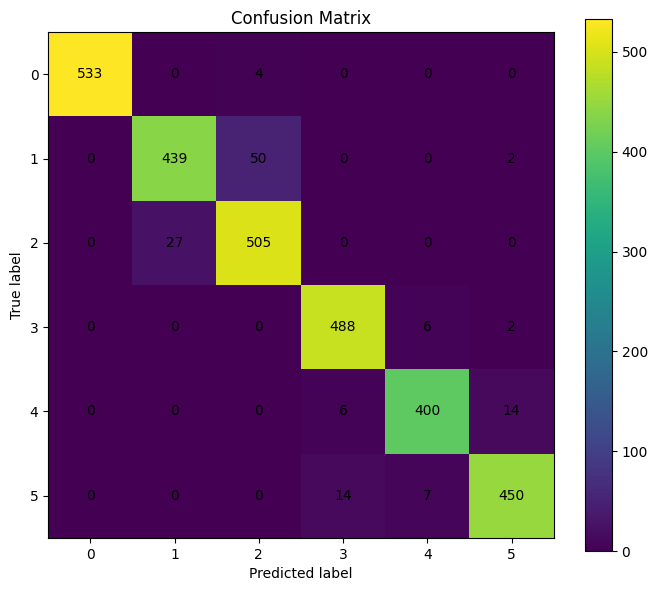

In [11]:
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 6))

# Simple Matplotlib heatmap (no seaborn dependency)
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

ax.set(
    title="Confusion Matrix",
    xlabel="Predicted label",
    ylabel="True label"
)

# Tick labels: numeric 0..5 by default
num_classes = cm.shape[0]
ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))

# Annotate counts
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


## 6) Classification report (precision, recall, F1)

This report gives a **per-class breakdown**:
- **Precision**: of the items predicted as class *k*, how many were correct?
- **Recall**: of the items that truly belong to class *k*, how many did we recover?
- **F1**: harmonic mean of precision and recall.

Macro/weighted averages summarize the overall performance across classes.


In [12]:
report = classification_report(y_true, y_pred, digits=4)
print(report)


              precision    recall  f1-score   support

           0     1.0000    0.9926    0.9963       537
           1     0.9421    0.8941    0.9175       491
           2     0.9034    0.9492    0.9258       532
           3     0.9606    0.9839    0.9721       496
           4     0.9685    0.9524    0.9604       420
           5     0.9615    0.9554    0.9585       471

    accuracy                         0.9552      2947
   macro avg     0.9560    0.9546    0.9551      2947
weighted avg     0.9556    0.9552    0.9552      2947



## 7) Final test accuracy

We compute the overall accuracy on the test set as an easy-to-interpret scalar.


In [13]:
test_accuracy = (y_true == y_pred).mean()
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


✅ Test Accuracy: 0.9552


## 8) Quick analysis and next steps

- If the **test accuracy** is close to your **validation accuracy**, your model generalizes well.
- Inspect the **confusion matrix** to see if any specific class is underperforming.
- If you observe systematic confusions, consider:
  - Slightly deeper/wider MLP (e.g., `[512, 256, 128]`) with careful regularization
  - Tweaking dropout (e.g., 0.2–0.4)
  - Learning rate adjustments or a scheduler
  - Class-weighted loss if you discover class imbalance

**Next notebook (optional)**: error analysis per class, plotting per-class precision/recall bars,
and exporting the trained model for inference (e.g., TorchScript or ONNX).
